# Training CNN with triplet loss

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install unrar
!unrar x /content/new_dataset.rar
x_train = np.load('/content/x_train_red.npy')
y_train = np.load('/content/y_train_red.npy')
x_val = np.load('/content/x_val_red.npy')
y_val = np.load('/content/y_val_red.npy')


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/new_dataset.rar

Extracting  x_test_red.npy                                                 2%  OK 
Extracting  x_train_red.npy                                               57% 67%  OK 
Extracting  x_val_red.npy                                                 99%  OK 
Extracting  y_test_red.npy                                                99%  OK 
Extracting  y_train_red.npy                                               99%  OK 
Extracting  y_val_red.npy                                                100%  OK 
All OK


In [ ]:
from torch.utils.data import Dataset

rng = np.random.default_rng()

class SiameseDataset(Dataset):

  def __init__(self, x, y, transform = None, number_of_samples = 20, number_of_classes = 500):
    self.x = x
    self.transform = transform
    self.y = y.reshape(-1)
    self.n = number_of_samples
    self.classes = np.arange(number_of_classes)

  def __getitem__(self, idx):
    anchor = self.x[idx//self.n][idx % self.n]
    positive = rng.choice(self.x[idx//self.n])
    negative_idxs = np.delete(self.classes, self.classes == idx//self.n)
    negative_idx = np.random.choice(negative_idxs)
    negative = rng.choice(self.x[negative_idx])

    positive = positive + rng.choice(self.x[negative_idx]) #mixture containing positive element
    negative = negative + rng.choice(self.x[negative_idx]) #mixture without positive element

    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative


  def __len__(self):
    return len(self.x)*self.n



class ValidationSiameseDataset(Dataset):

  def __init__(self, x, y, transform = None, number_of_samples = 10, number_of_classes = 500):
    self.x = x
    self.transform = transform
    self.y = y.reshape(-1)
    self.n = number_of_samples
    self.classes = np.arange(number_of_classes)

  def __getitem__(self, idx):
    anchor = self.x[idx//self.n][idx % self.n]
    positive = rng.choice(self.x[idx//self.n])
    negative_idxs = np.delete(self.classes, self.classes == idx//self.n)
    negative_idx = np.random.choice(negative_idxs)
    negative = rng.choice(self.x[negative_idx])

    positive = positive + rng.choice(self.x[negative_idx]) #mixture containing positive element
    negative = negative + rng.choice(self.x[negative_idx]) #mixture without positive element

    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative


  def __len__(self):
    return len(self.x)*self.n

def transformation(x):
  x = x/np.max(x)
  x = x + np.random.normal(0,0.005,x.shape[0])
  x = torch.Tensor(x)
  return x

from torch import nn
class SiameseNet(nn.Module):

    def __init__(self, latent_dim):
      super().__init__()
      self.latent_dim = latent_dim
      self.model = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16,kernel_size=21, padding = 'same'),
                                  nn.MaxPool1d(kernel_size=2, stride=2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(16),
                                  nn.Conv1d(16, 32, 11, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(32),
                                  nn.Conv1d(32, 64, 5, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(64),

                                 nn.Flatten(),
                                 nn.Linear(64*625, self.latent_dim))


    def _forward(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      # normalize embedding to unit vector
      out = torch.nn.functional.normalize(out)
      return out


    def predict(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      out = torch.nn.functional.normalize(out)
      return out

    def forward(self, anchor, positive, negative, latent_dim):
        output1 = self._forward(anchor)
        output2 = self._forward(positive)
        output3 = self._forward(negative)

        return output1, output2, output3


def train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim):
    loss_history = []
    l = []
    l_val = []
    f_p_train = []
    f_p_val = []

    for epoch in range(0, num_epochs):
      model.train()
      for i, batch in enumerate(train_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss, fraction_pos = criterion_train(output_anc, output_pos, output_neg)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          l.append(loss.item())
          f_p_train.append(fraction_pos.item())

      model.eval()
      for i, batch in enumerate(val_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss_val, fraction_pos_val = criterion_val(output_anc, output_pos, output_neg)
          l_val.append(loss_val.item())
          f_p_val.append(fraction_pos_val.item())
      scheduler.step()
      f_p_train_last_ep =  torch.tensor(f_p_train[-len(train_loader):-1]).mean()
      f_p_val_last_ep = torch.tensor(f_p_val[-len(val_loader):-1]).mean()
      print("Epoch {} with {:.4f} fraction and {:.4f} val_fraction".format(epoch, f_p_train_last_ep, f_p_val_last_ep))

    return l, l_val, f_p_train, f_p_val

import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin, semi_hard):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.semi_hard = semi_hard

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = 1.0 - F.cosine_similarity(anchor, positive)
        distance_negative = 1.0 - F.cosine_similarity(anchor, negative)
        losses = distance_positive - distance_negative + self.margin
        losses = torch.where(losses > self.semi_hard, losses, torch.zeros(losses.shape).to(device))
        return losses.sum()/(torch.count_nonzero(losses)+1e-16) if size_average else losses.sum(), torch.count_nonzero(losses)/len(losses)

from torch.utils.data import  DataLoader



In [ ]:
train_dataset = SiameseDataset(x_train[100:], y_train[100:], transform = transformation, number_of_classes = 400)
val_dataset = ValidationSiameseDataset(x_val[100:], y_val[100:], transform=transformation, number_of_classes = 400)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

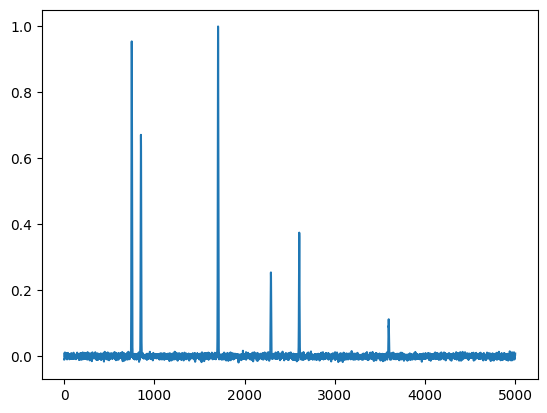

In [ ]:
val_data = list(val_dataset)
plt.plot(val_data[0][1].numpy()) #example of processed data: positive mixture

In [ ]:
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 64
model = SiameseNet(latent_dim).to(device)
criterion_train = TripletLoss(margin = 1, semi_hard = 0.3)
criterion_val = TripletLoss(margin = 1, semi_hard = 0.3)

optimizer = optim.AdamW(model.parameters(), lr=4e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,12,16], gamma=0.5)
num_epochs = 16

start = time.time()
l, l_val, f_p_train, f_p_val = train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)
elapsed = time.time() - start
print(f"Time: {elapsed} s")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 with 0.6932 fraction and 0.6132 val_fraction
Epoch 1 with 0.5861 fraction and 0.5834 val_fraction
Epoch 2 with 0.5664 fraction and 0.5454 val_fraction
Epoch 3 with 0.5500 fraction and 0.5496 val_fraction
Epoch 4 with 0.5214 fraction and 0.5247 val_fraction
Epoch 5 with 0.5290 fraction and 0.5330 val_fraction
Epoch 6 with 0.5222 fraction and 0.5267 val_fraction
Epoch 7 with 0.5178 fraction and 0.5310 val_fraction
Epoch 8 with 0.5091 fraction and 0.5113 val_fraction
Epoch 9 with 0.5023 fraction and 0.5232 val_fraction
Epoch 10 with 0.5115 fraction and 0.5234 val_fraction
Epoch 11 with 0.4975 fraction and 0.5237 val_fraction
Epoch 12 with 0.5084 fraction and 0.5197 val_fraction
Epoch 13 with 0.5030 fraction and 0.5249 val_fraction
Epoch 14 with 0.4971 fraction and 0.5355 val_fraction
Epoch 15 with 0.5054 fraction and 0.5106 val_fraction
Time: 268.88460087776184 s


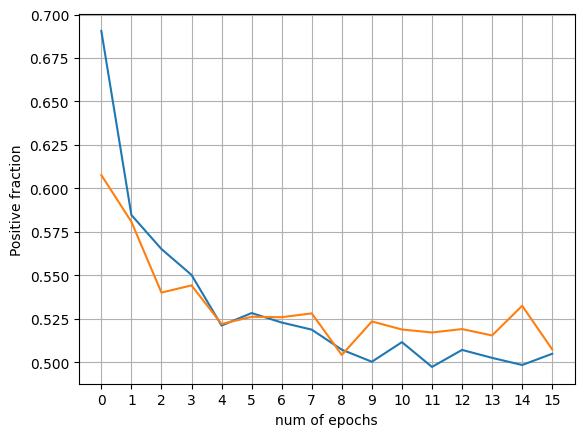

In [ ]:
l_plot_val = np.array(f_p_val).reshape(16, 32).mean(1)
l_plot_train = np.array(f_p_train).reshape(16, 63).mean(1)
plt.plot([i for i in range(len(l_plot_val))], l_plot_train, l_plot_val)
plt.ylabel('Positive fraction')
plt.xlabel('num of epochs')
x = range(0, len(l_plot_val), len(l_plot_val) // num_epochs)
labels = range(0, num_epochs)
plt.xticks(x, labels)
plt.grid()
plt.show()

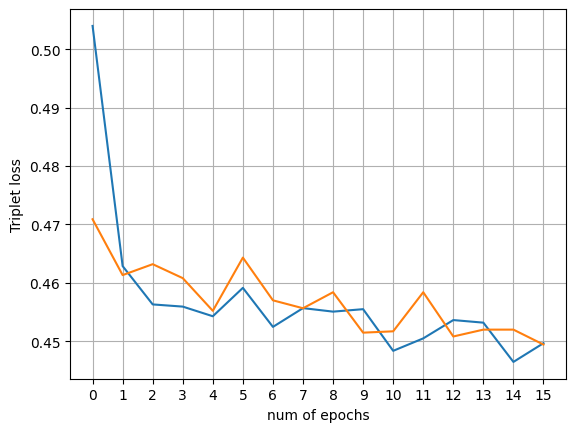

In [ ]:
l_plot_val = np.array(l_val).reshape(16, 32).mean(1)
l_plot_train = np.array(l).reshape(16, 63).mean(1)
plt.plot([i for i in range(len(l_plot_val))], l_plot_train, l_plot_val)
plt.ylabel('Triplet loss')
plt.xlabel('num of epochs')
x = range(0, len(l_plot_val), len(l_plot_val) // num_epochs)
labels = range(0, num_epochs)
plt.xticks(x, labels)
plt.grid()
plt.show()

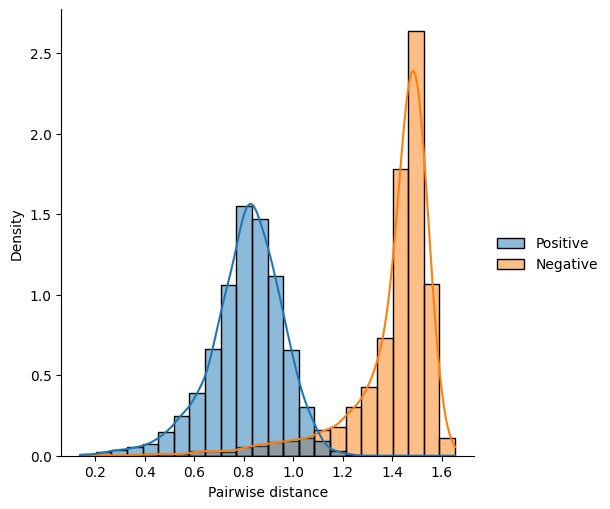

In [ ]:
import torch.nn.functional as F
def validate(model, val_loader, latent_dim):
    distances_pos = []
    distances_neg = []
    model.eval()

    for i, batch in enumerate(val_loader, 0):
        anc, pos, neg = batch
        output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)

        distance_pos = F.pairwise_distance(output_anc, output_pos).detach().cpu()
        distance_neg = F.pairwise_distance(output_anc, output_neg).detach().cpu()

        distances_pos.append(distance_pos)
        distances_neg.append(distance_neg)

    return distances_pos, distances_neg

d_pos, d_neg = validate(model, val_loader, latent_dim = 64)
pos_dist = []
neg_dist = []
for d in d_pos[:-1]:
  d = d.detach().cpu().numpy()
  pos_dist.append(d)
for d in d_neg[:-1]:
  d = d.detach().cpu().numpy()
  neg_dist.append(d)

neg_dist = np.concatenate(np.array(neg_dist), axis=0, dtype = object)
pos_dist = np.concatenate(np.array(pos_dist), axis=0, dtype = object)

import seaborn as sns

distances = {"Positive": pos_dist, "Negative": neg_dist}

ax = sns.displot(distances, kde=True, stat="density")
ax.set(xlabel="Pairwise distance")
plt.show()

# Binary mixture

In [ ]:
def transformation(x):
  x = x/np.max(x)
  x = torch.Tensor(x)
  return x

In [ ]:
def accuracy_for_mixture(pred, cor, mixture=2):
  accuracy = np.zeros((mixture))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

def get_individual_emb(x_train, y_train, model, num_classes=500):
    molecules_embeddings = []
    label = []

    data_train = x_train.reshape(-1, 5000)
    row_max = data_train.max(axis=1)
    data_train = np.abs(data_train / row_max[:, np.newaxis])
    data_train = data_train.reshape(num_classes, -1, 5000)
    label_train = y_train.reshape(num_classes, -1)

    for i in range(0, data_train.shape[0]):
        molecules = torch.Tensor(data_train[i]).to(device)
        embeddings = model.predict(molecules).detach().cpu().numpy()
        emb_mean = embeddings.mean(axis=0)
        molecules_embeddings.append(emb_mean/np.linalg.norm(emb_mean))
        label.append(label_train[i][0])
    return np.array(molecules_embeddings), np.array(label)

In [ ]:
molecules_embeddings, label = get_individual_emb(x_train[:100], y_train[:100], model, num_classes=100)

In [ ]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [ ]:
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)//2, 2))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)//2, 64))

import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

s = [x for x in range(0,len(label))]
s = set(s)
n = 2
a = findsubsets(s, n)

In [ ]:
l = 0
for i in range(len(a)):
    mixture_train[l] = molecules_embeddings[[a[i]]].squeeze(0).sum(axis=0)
    mixture_train[l] = mixture_train[l]/np.linalg.norm(mixture_train[l])
    label_train[l] = label[[a[i]]]
    l = l+1

In [ ]:
rng = np.random.default_rng()

class SiameseDatasetTest(Dataset):

  def __init__(self, x, y, transform = None, number_of_samples = 9, number_of_classes=500, mixture = 4):
    self.x = x
    self.transform = transform
    self.y = y
    self.n = number_of_samples
    #self.classes = np.unique(self.y)
    self.classes = np.arange(number_of_classes)
    self.mixture = mixture

  def __getitem__(self, idx):
    labels = [self.y[idx//self.n][idx % self.n]] # [123]
    element = self.x[idx//self.n][idx % self.n]
    negative_idxs = np.delete(self.classes, self.classes == idx//self.n)
    for i in range(self.mixture-1):
        negative_idx = int(np.random.choice(negative_idxs))
        labels.append(self.y[negative_idx][0])
        element = element + rng.choice(self.x[negative_idx])

    if self.transform is not None:
      element = self.transform(element)
    return element, np.array(labels)


  def __len__(self):
    return len(self.x)*self.n

test_dataset = SiameseDatasetTest(x_test, y_test, transform=transformation,number_of_samples = 9, number_of_classes=100, mixture = 2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


classification_data_test = []
correct_test = []
model.eval()
for i, batch in enumerate(test_loader, 0):
          element, labels = batch
          embedding = model.predict(element.to(device))
          classification_data_test.append(embedding.detach().cpu().numpy())
          correct_test.append(labels)

In [ ]:
classification_data_test = np.array(classification_data_test).reshape(-1, latent_dim)
correct_test = np.array(correct_test).reshape(-1,2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [ ]:
accuracy = accuracy_for_mixture(preds, correct_test, mixture=2)

In [ ]:
print('.....Accuracy.....')
print('1 of 2 ......', accuracy[0])
print('2 of 2 ......', accuracy[1])

.....Accuracy.....
1 of 2 ...... 0.9922222222222222
2 of 2 ...... 0.92


# Ternary mixture

In [ ]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label)-2)//2//3, 3))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label)-2)//2//3, 64))

import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

s = [x for x in range(0,len(label))]
s = set(s)
n = 3
a = findsubsets(s, n)

In [ ]:
l = 0
for i in range(len(a)):
    mixture_train[l] = molecules_embeddings[[a[i]]].squeeze(0).sum(axis=0)
    mixture_train[l] = mixture_train[l]/np.linalg.norm(mixture_train[l])
    label_train[l] = label[[a[i]]]
    l = l+1

In [ ]:
test_dataset = SiameseDatasetTest(x_test, y_test, transform=transformation,number_of_samples = 9, number_of_classes=100, mixture = 3)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [ ]:
classification_data_test = []
correct_test = []
model.eval()
for i, batch in enumerate(test_loader, 0):
          element, labels = batch
          embedding = model.predict(element.to(device))
          classification_data_test.append(embedding.detach().cpu().numpy())
          correct_test.append(labels)

classification_data_test = np.array(classification_data_test).reshape(-1, latent_dim)
correct_test = np.array(correct_test).reshape(-1,3)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)
accuracy = accuracy_for_mixture(preds, correct_test, mixture=3)

In [ ]:
print('.....Accuracy.....')
print('1 of 3 ......', accuracy[0])
print('2 of 3 ......', accuracy[1])
print('3 of 3 ......', accuracy[2])


.....Accuracy.....
1 of 3 ...... 0.9955555555555555
2 of 3 ...... 0.9655555555555555
3 of 3 ...... 0.7888888888888889


# Quaternary mixture

In [ ]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label)-2)*(len(label)-3)//2//3//4, 4))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label)-2)*(len(label)-3)//2//3//4, 64))

import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

s = [x for x in range(0,len(label))]
s = set(s)
n = 4
a = findsubsets(s, n)

In [ ]:
l = 0
for i in range(len(a)):
    mixture_train[l] = molecules_embeddings[[a[i]]].squeeze(0).sum(axis=0)
    mixture_train[l] = mixture_train[l]/np.linalg.norm(mixture_train[l])
    label_train[l] = label[[a[i]]]
    l = l+1

In [ ]:
test_dataset = SiameseDatasetTest(x_test, y_test, transform=transformation,number_of_samples = 9, number_of_classes=100, mixture = 4)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [ ]:
classification_data_test = []
correct_test = []
model.eval()
for i, batch in enumerate(test_loader, 0):
          element, labels = batch
          embedding = model.predict(element.to(device))
          classification_data_test.append(embedding.detach().cpu().numpy())
          correct_test.append(labels)

classification_data_test = np.array(classification_data_test).reshape(-1, latent_dim)
correct_test = np.array(correct_test).reshape(-1,4)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)
accuracy = accuracy_for_mixture(preds, correct_test, mixture=4)

In [ ]:
print('.....Accuracy.....')
print('1 of 4 ......', accuracy[0])
print('2 of 4 ......', accuracy[1])
print('3 of 4 ......', accuracy[2])
print('4 of 4 ......', accuracy[3])

.....Accuracy.....
1 of 4 ...... 0.9933333333333333
2 of 4 ...... 0.96
3 of 4 ...... 0.8477777777777777
4 of 4 ...... 0.5944444444444444


# Explainability


Reconstruct feature map for last convolutional layer

In [ ]:
print(model)

SiameseNet(
  (model): Sequential(
    (0): Conv1d(1, 16, kernel_size=(21,), stride=(1,), padding=same)
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=same)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=40000, out_features=64, bias=True)
  )
)


In [ ]:
class ForwardHook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output):
        self.activation = output.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
      self.hook.remove()

In [ ]:
anchor, positive, negative  = next(iter(train_loader))

In [ ]:
anchor, positive, negative = anchor[0], positive[0], negative[0]

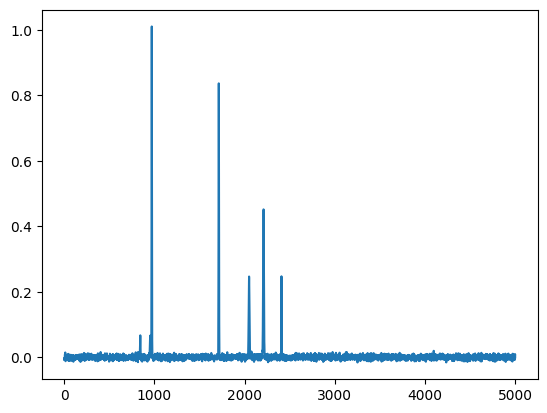

In [ ]:
plt.plot(positive.detach().cpu().numpy())

In [ ]:
with ForwardHook(model.model[8]) as forward_hook:
    output = model._forward(positive.to(device))
    activation_positive_trained = forward_hook.activation

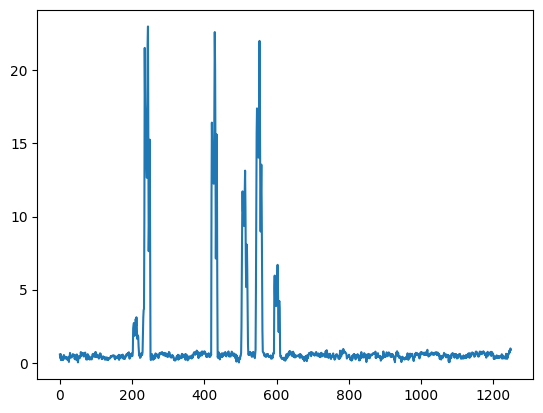

In [ ]:
plt.plot(activation_positive_trained.detach().cpu().numpy()[0][0])